Brief Summary:

This notebook describes a full data mining activity involving the exploration of a dataset related to Linear B-cell epitopes. The objective is to predict epitopes for a real human pathogen, the protozoan parasite Trypanosoma cruzi, which causes the tropical disease Chagas. My workflow involved extensive Exploratory Data Analysis (EDA), adequate Data Pre-Processing (DPP), and rigorous modeling/pipeline development, which included comparing models to find the best one, exploring sampling techniques to handle extreme imbalance, and hyperparameter tuning. After a comprehensive process consisting of handling several issues with the dataset, most notably its extreme imbalance, I built an XGBoost pipeline with Balanced Bagging and hyperparameters: estimator__learning_rate: 0.12, estimator__max_depth: 6, estimator__n_estimators: 150, max_features: 0.5, max_samples: 1.0, n_estimators: 25, sampler: None, at threshold: 0.10. The accuracy score was not balanced enough so trained a Deep Neural Network (DNN) model on the dataset with better accuracy results.

Exploratory Data Analysis (EDA); Cells 1 - 10:

My workflow began with an exploration of the dataset. A preview and/or visualization of the data structure and features distribution revealed that:

All Info columns are not important for modelling, so should be dropped except for Info_group, which is the grouping variable for my train/test splits which was was done using Group aware GroupShuffleSplit.
Feat_ columns (numerical features) which are to be used for modeling are continuous floats, so good for modelling.
The value counts for the target variable (Class) show that it is severely imbalanced (-1 = 99.3%, 1 = 0.7%); therefore, standard models will perform poorly on it, as predictions will mirror the majority class. Consequently, it will be imperative to use class balancing strategies (e.g., SMOTE, RandomOverSampler, and/or class weights) and a group-aware split like GroupShuffleSplit to avoid leakage whilst splitting the data for training/testing.
There were no missing values, no placeholders, and no duplicates found.
Histograms revealed that some features were densely packed, while others were spread out, making it necessary for normalization or standardization with a capable scaler (RobustScaler). Skewness observed in histograms shows it will be best to use Tree-based models during modelling.
Correlation heatmap revealed multi-collinearity, hence the need to explore the option of dimensionality reduction like PCA and Boruta.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from scipy import stats
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, ADASYN
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import RandomizedSearchCV
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import ClusterCentroids
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import warnings
from requests.packages.urllib3.exceptions import DependencyWarning
warnings.filterwarnings('ignore', category=DependencyWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', message='ConvergenceWarning')
warnings.filterwarnings('ignore', message='overflow encountered')
warnings.filterwarnings('ignore', message='invalid value encountered')
warnings.filterwarnings('ignore', message='Unable to find acceptable character detection dependency')


df= pd.read_csv('df.csv', low_memory= False)
df.head()

,Info_PepID,Info_protein_id,Info_pos,Info_AA,Info_epitope_id,Info_sourceOrg_id,Info_host_id,Info_nPos,Info_nNeg,Info_type,...,feat_esm2_1271,feat_esm2_1272,feat_esm2_1273,feat_esm2_1274,feat_esm2_1275,feat_esm2_1276,feat_esm2_1277,feat_esm2_1278,feat_esm2_1279,feat_esm2_1280
0,XP_818691.1:1,XP_818691.1,385,T,"264163,299086,311183,368360,410517,413069","353153,353153,353153,353153,353153,353153",9606,"0,0,0,0,0,0","1,1,1,1,1,1",Epitope containing region/antigenic site,...,0.186531,0.120602,-0.182094,0.335078,-0.219101,0.091682,-0.161745,0.062886,-0.200978,-0.065332
1,XP_818691.1:1,XP_818691.1,386,C,"264163,299086,311183,368360,413069","353153,353153,353153,353153,353153",9606,"0,0,0,0,0","1,1,1,1,1",Epitope containing region/antigenic site,...,-0.192275,0.096834,-0.079729,0.059896,-0.179158,0.156257,0.039641,-0.071312,-0.169275,0.065096
2,XP_818691.1:1,XP_818691.1,387,F,"264163,299086,311183,413069","353153,353153,353153,353153",9606,"0,0,0,0","1,1,1,1",Epitope containing region/antigenic site,...,-0.127347,0.090737,-0.088293,0.320981,-0.183980,0.186845,0.130870,0.054881,-0.183704,0.089822
3,XP_818691.1:1,XP_818691.1,388,G,"264163,311183,413069","353153,353153,353153",9606,"0,0,0","1,1,1",Epitope containing region/antigenic site,...,0.086008,0.100702,-0.209549,0.132883,-0.236305,0.313711,-0.169240,0.004743,-0.032056,0.079301
4,XP_818691.1:1,XP_818691.1,389,I,"264163,413069","353153,353153",9606,"0,0","1,1",Epitope containing region/antigenic site,...,0.007879,0.202566,-0.006222,0.263450,-0.088345,0.317649,-0.066709,0.036689,0.018426,0.188010


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Columns: 1650 entries, Info_PepID to feat_esm2_1280
dtypes: float64(1628), int64(11), object(11)
memory usage: 566.5+ MB


In [3]:
df.describe() 

,Info_pos,Info_host_id,Info_group,Class,feat_Entropy,feat_MolWeight,feat_AAtypes_Tiny,feat_AAtypes_Small,feat_AAtypes_Aliphatic,feat_AAtypes_Aromatic,...,feat_esm2_1271,feat_esm2_1272,feat_esm2_1273,feat_esm2_1274,feat_esm2_1275,feat_esm2_1276,feat_esm2_1277,feat_esm2_1278,feat_esm2_1279,feat_esm2_1280
count,45000.000000,45000.0,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,...,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,319.781111,9606.0,129.960289,-0.985244,2.963995,1883.791208,0.354167,0.574204,0.280793,0.072588,...,0.038835,0.014660,-0.053453,0.028602,-0.046709,-0.041111,0.062953,-0.043011,0.052560,0.093800
std,275.101398,0.0,100.204808,0.171155,0.385034,148.303010,0.159486,0.175301,0.152201,0.079166,...,0.152642,0.139088,0.129500,0.154066,0.134989,0.153164,0.140340,0.153867,0.167224,0.150673
min,1.000000,9606.0,9.000000,-1.000000,0.699843,1198.130000,0.000000,0.000000,0.000000,0.000000,...,-0.702291,-0.777684,-0.711707,-0.534939,-0.776880,-0.822042,-0.581313,-0.840151,-0.791998,-0.601091
25%,120.000000,9606.0,42.000000,-1.000000,2.789898,1788.850000,0.266667,0.466667,0.200000,0.000000,...,-0.056009,-0.066439,-0.130491,-0.077223,-0.132446,-0.141362,-0.029193,-0.135852,-0.053991,-0.003531
50%,243.000000,9606.0,103.000000,-1.000000,3.006239,1886.910000,0.333333,0.600000,0.266667,0.066667,...,0.043914,0.023128,-0.050389,0.021100,-0.045311,-0.039615,0.064743,-0.036643,0.059092,0.095492
75%,424.000000,9606.0,191.000000,-1.000000,3.189898,1986.180000,0.466667,0.666667,0.333333,0.133333,...,0.141148,0.106192,0.028364,0.125858,0.037470,0.057832,0.156408,0.056991,0.166234,0.190922
max,1658.000000,9606.0,376.000000,1.000000,3.906891,2415.760000,1.000000,1.000000,1.000000,0.533333,...,0.765174,0.604259,0.616022,0.894539,0.682663,0.793851,0.754429,0.672107,0.716797,0.896703


In [4]:
df['Class'].value_counts(normalize=True)

Class
-1    0.992622
 1    0.007378
Name: proportion, dtype: float64

In [5]:
df.isnull().sum().sum()

0

In [6]:
df.duplicated().sum()

0

In [7]:
for col in df.columns:
    if df[col].dtype == 'object':
        empty_count = df[col].astype(str).str.strip().eq('').sum()
        if empty_count > 0:
            print(f"Column '{col}': {empty_count} empty/whitespace string(s) found.")

In [8]:
placeholder_values = ['-0', 'NA', '-999']
for col in df.columns:
    hidden_values = df[col].astype(str).isin(placeholder_values)
    if hidden_values.sum() > 0:
        print(f"Column '{col}': {hidden_values.sum()} placeholder value(s) found (e.g. {placeholder_values}).")

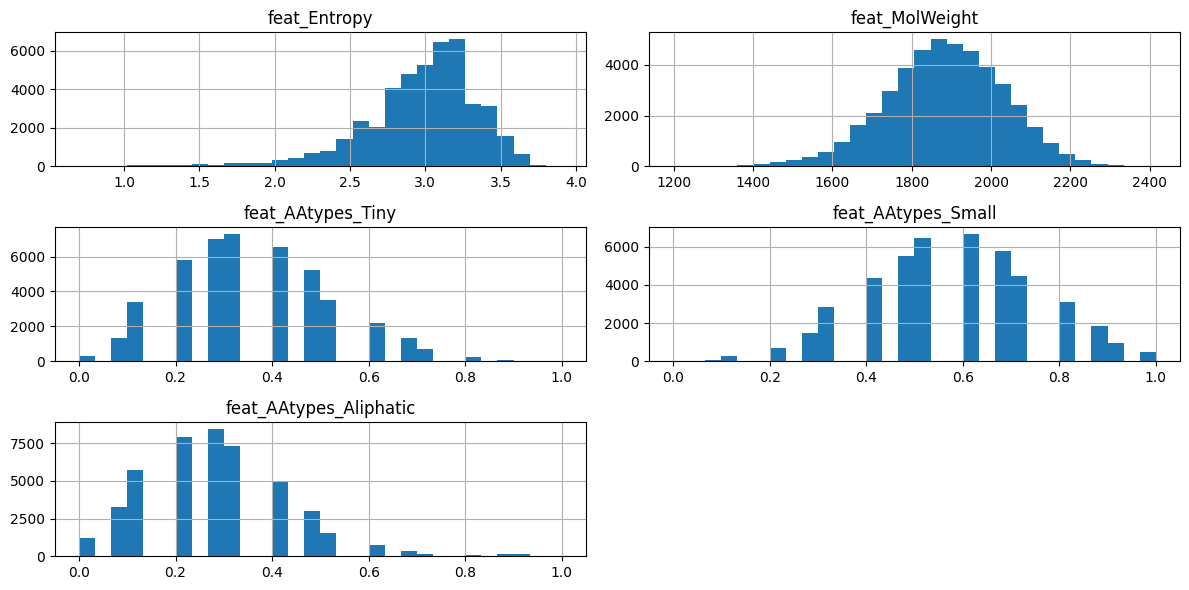

In [9]:
df[[col for col in df.columns if 'feat_' in col][:5]].hist(bins=30, figsize=(12, 6))
plt.tight_layout()
plt.show()

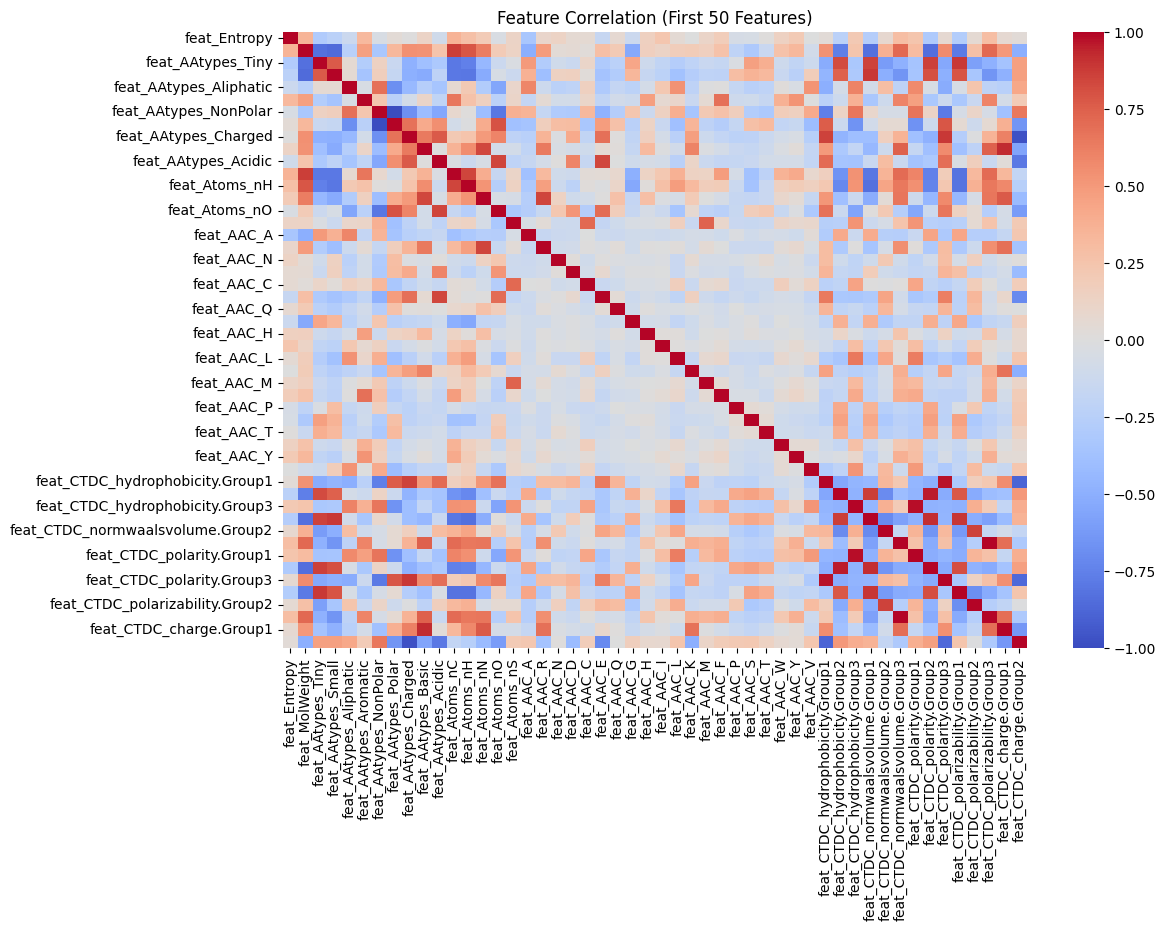

In [10]:
feat_subset = df[[col for col in df.columns if 'feat_' in col][:50]]
corr = feat_subset.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation (First 50 Features)')
plt.show()

Data Pre-Processing (DPP); Cells 11 - 16:

Split the data using GroupShuffleSplit to avoid data leakage.
Employed Z-score and IQR methods to check for outliers. High proportions of the data were revealed as outliers, which confirms the earlier suspicion that a Robust scaler rather than a standard scaler will be appropriate for this data's distribution.
Used Robust scaler to scale features on a common scale to get them ready for feature reduction.
Performed features reduction using PCA (95% and 90% variance retention), to get data ready for modelling.

In [11]:
## Define features (X) and label target (y), keeping Info_group for splitting
feat_cols = [col for col in df.columns if col.startswith('feat_')]
X = df[feat_cols]
y = df['Class']
groups = df['Info_group']

In [12]:
## Split the dataset for training, validation and testing while using Group Shuffle Split
splitter_test = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_df, test_df = next(splitter_test.split(X, y, groups))
X_test, y_test = X.iloc[test_df], y.iloc[test_df]
X_train_val, y_train_val, groups_train_val = X.iloc[train_df], y.iloc[train_df], groups.iloc[train_df]
splitter_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter_val.split(X_train_val, y_train_val, groups_train_val))
X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

print(f"Total samples: {len(X)}")
print(f"Final Test Set: {len(X_test)} samples (20% of total)")
print(f"Training Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")

Total samples: 45000
Final Test Set: 9218 samples (20% of total)
Training Set: 27269 samples
Validation Set: 8513 samples


In [13]:
## To check for outliers in the dataset using Z-score and IQR
feat_cols = X_train.columns

## Using Z-score method (|z| > 3) to detect outliers 
z_scores = np.abs(stats.zscore(X_train, nan_policy='omit'))
outliers_z = (z_scores > 3).any(axis=1).sum()
print('Z-score outliers in training set:', outliers_z)

## Using IQR to check for outliers
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((X_train < (Q1 - 1.5 * IQR)) | (X_train > (Q3 + 1.5 * IQR))).any(axis=1).sum()
print('IQR Outliers in training set:', outliers_iqr)

Z-score outliers in training set: 22566
IQR Outliers in training set: 27175


In [14]:
## Scaling dataset using Robust scaler 
scaler = RobustScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_val = scaler.transform(X_val)

print('Feature medians (train):', np.median(scaled_X_train, axis=0)[:5])
print('IQR (train):', np.subtract(*np.percentile(scaled_X_train, [75, 25], axis=0))[:5])

Feature medians (train): [0. 0. 0. 0. 0.]
IQR (train): [1. 1. 1. 1. 1.]


In [15]:
## Dimensionality reduction using PCA
pca = PCA(n_components=0.95, random_state=42) ## Initialize PCA to retain 95% of variance
X_train_pca = pca.fit_transform(scaled_X_train) ## Fit and transform into data
X_val_pca = pca.transform(scaled_X_val)

print('Number of PCA components:', pca.n_components_)
print('X_train_pca_shape:', X_train_pca.shape)
print('X_val_pca_shape:', X_val_pca.shape)

Number of PCA components: 914
X_train_pca_shape: (27269, 914)
X_val_pca_shape: (8513, 914)


In [16]:
pca = PCA(n_components=0.90, random_state=42) ## Retain 90% of variance
X_train_pca = pca.fit_transform(scaled_X_train)
X_val_pca = pca.transform(scaled_X_val)

print('Number of PCA components:', pca.n_components_)
print('X_train_pca_shape:', X_train_pca.shape)
print('X_val_pca_shape:', X_val_pca.shape)

Number of PCA components: 634
X_train_pca_shape: (27269, 634)
X_val_pca_shape: (8513, 634)


PCA Evaluation, and Addressing Class Imbalance (Cells 17 - 23):

Built and evaluated a PCA-based pipeline, using Random Forest as a baseline model. Results were heavily influenced by class imbalance.
Inserted SMOTE in the pipeline, so that the classifier would weigh the minority class more heavily to deal with the heavy imbalance class.
Ran a confusion matrix to statistically visualize that class imbalance was heavily influencing results.
Scatter plot visualization confirmed the same in cell 24 below. The minority class (1) sits buried in the blue mass of the majority class (-1). This tells us that the classes are not linearly separable in the feature subspace that PCA captures. Using Random Forest (with SMOTE and class weights) made no difference either. Accordingly, skipping PCA and adopting another approach that works in the full feature space became inescapable.

In [17]:
## Train model using Random Forest Classifier
def evaluate_pca(n_variance):
    pca = PCA(n_components=n_variance, random_state=42)
    pipeline = Pipeline([('scaler', RobustScaler()),
                         ('pca', pca), 
                         ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))])
    pipeline.fit(X_train, y_train)
    X_val_pred = pipeline.predict(X_val)
    return balanced_accuracy_score(y_val, X_val_pred)

bal_acc_95 = evaluate_pca(0.95)
bal_acc_90 = evaluate_pca(0.90)
print(f'95% var (932 comps) -> Balanced Acc: {bal_acc_95:.4f}')
print(f'90% var (650 comps) -> Balanced Acc: {bal_acc_90:.4f}')

95% var (932 comps) -> Balanced Acc: 0.5000
90% var (650 comps) -> Balanced Acc: 0.5000


In [18]:
## Checks for counts of imbalance in training and validation class
print('Train class counts:\n', y_train.value_counts())
print('Val class counts:\n', y_val.value_counts())

Train class counts:
 Class
-1    27088
 1      181
Name: count, dtype: int64
Val class counts:
 Class
-1    8416
 1      97
Name: count, dtype: int64


In [19]:
## Inserting SMOTE in the pipeline to handle class imbalance properly
pipeline_smote = ImbPipeline([('scaler', RobustScaler()),
                              ('pca', pca),
                              ('smote', SMOTE(random_state=42)),
                              ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
pipeline_smote.fit(X_train, y_train)

val_smote_pred = pipeline_smote.predict(X_val)
bal_acc_smote = balanced_accuracy_score(y_val, val_smote_pred)

print(f'Balanced Accuracy with SMOTE: {bal_acc_smote:.4f}')

Balanced Accuracy with SMOTE: 0.5000


In [20]:
## Telling classifier to use class weights to balance class
pipeline_cw = Pipeline([('scaler', RobustScaler()),
                        ('pca', pca),
                        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42))])
pipeline_cw.fit(X_train, y_train)
bal_acc_cw = balanced_accuracy_score(y_val, pipeline_cw.predict(X_val))

print(f'Balanced Accuracy with class_weight: {bal_acc_cw:.4f}')

Balanced Accuracy with class_weight: 0.5000


In [21]:
## Still getting the same prediction, so I will run a confusion matrix to visualize
cm = confusion_matrix(y_val, val_smote_pred, labels=[1, -1])
print('Confusion Matrix (rows=true, cols=pred):\n', cm)
print('Classification Report:')
print(classification_report(y_val, val_smote_pred, labels=[1, -1], zero_division=0))

Confusion Matrix (rows=true, cols=pred):
 [[   0   97]
 [   0 8416]]
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        97
          -1       0.99      1.00      0.99      8416

    accuracy                           0.99      8513
   macro avg       0.49      0.50      0.50      8513
weighted avg       0.98      0.99      0.98      8513



In [22]:
## Re-run SMOTE before PCA in pipeline to get better results
fixed_pipeline = ImbPipeline([('scaler', RobustScaler()),
                               ('smote', SMOTE(random_state=42)),
                               ('pca', PCA(n_components=0.90, random_state=42)),
                               ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
fixed_pipeline.fit(X_train, y_train)
fixed_y_pred = fixed_pipeline.predict(X_val)

print('Confusion Matrix:\n', confusion_matrix(y_val, fixed_y_pred, labels=[1, -1]))
print('\nClassification Report:\n', classification_report(y_val, fixed_y_pred, labels=[1, -1],zero_division=0))
print(f'\nBalanced Accuracy: {balanced_accuracy_score(y_val, fixed_y_pred):.4f}')

Confusion Matrix:
 [[   0   97]
 [   0 8416]]

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        97
          -1       0.99      1.00      0.99      8416

    accuracy                           0.99      8513
   macro avg       0.49      0.50      0.50      8513
weighted avg       0.98      0.99      0.98      8513


Balanced Accuracy: 0.5000


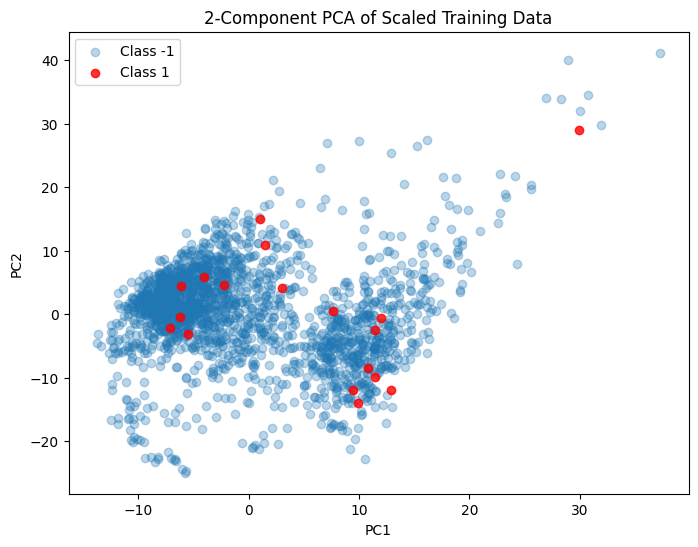

In [23]:
## Scatter plot to visualize whether the classes are separable
sample_y_train = y_train.sample(2000, random_state=42).index ##Using small sample for speed
X_sub = X_train.loc[sample_y_train]
y_sub = y_train.loc[sample_y_train]

scaled_X_sub = scaler.transform(X_sub)
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(scaled_X_sub)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[y_sub==-1,0], X_pca2[y_sub==-1,1], alpha=0.3, label='Class -1')
plt.scatter(X_pca2[y_sub==1,0], X_pca2[y_sub==1,1], alpha=0.8, label='Class 1', color='red')
plt.title('2-Component PCA of Scaled Training Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

Model Fitting, Handling Class Imbalance through Sampling (Cells 24 - 27):

Utilized XGBoost without PCA, which is better at mining weak signals from noisy, high-dimensional data, and evaluated it.
Wrapped the XGBoost pipeline in a GroupKFold to get a robust Cross-Validation (CV) estimate of balanced accuracy.
Tuned XGBoost + SMOTE gave a good generalized balanced accuracy of 0.60.
In exploring further options for getting a better result, a sampler comparison between SMOTE, ADASYN, SMOTETomek, SMOTEENN, Centroids, and Balanced Bagging (BB) revealed BB to be the best choice of sampler to combine with the XGBoost base estimator.

In [24]:
## Build Pipeline without dimensionality reduction
## First transform class labels from [-1, 1] to [0, 1] for training and validation because of xgboost
xgb_y_train = y_train.copy()
xgb_y_train = xgb_y_train.replace({-1:0, 1:1})
xgb_y_val = y_val.copy()
xgb_y_val = xgb_y_val.replace({-1:0, 1:1})

ratio = len(xgb_y_train[xgb_y_train==0]) / len(xgb_y_train[xgb_y_train==1])
xgb_pipeline = ImbPipeline([('scaler', RobustScaler()),
                            ('smote', SMOTE(random_state=42)),
                            ('clf', xgb.XGBClassifier(objective='binary:logistic',
                                                      scale_pos_weight=ratio,
                                                      eval_metric='logloss',
                                                      random_state=42))])
## Fit and predict
xgb_pipeline.fit(X_train, xgb_y_train)
y_prob = xgb_pipeline.predict_proba(X_val)[:, 1]

## Choose a threshold to maximize balanced accuracy
best_score = 0
best_thresh = 0.5
for thresh in [i/100 for i in range(1, 100)]:
    ## Convert back to original labels for evaluation
    y_pred = (y_prob >= thresh).astype(int)
    y_pred = np.where(y_pred == 0, -1, 1)
    score = balanced_accuracy_score(y_val, y_pred)
    if score > best_score:
        best_score, best_thresh = score, thresh

print(f'Best balanced accuracy {best_score:.4f} at threshold {best_thresh:.2f}')

## Final evaluation
final_y_pred = (y_prob >= best_thresh).astype(int)
final_y_pred = np.where(final_y_pred == 0, -1, 1) ## Convert back to original labels
print('Confusion Matrix:\n', confusion_matrix(y_val, final_y_pred, labels=[1, -1]))
print('\nClassification Report:\n', classification_report(y_val, final_y_pred, labels=[1, -1], zero_division=0))

Best balanced accuracy 0.4999 at threshold 0.90
Confusion Matrix:
 [[   0   97]
 [   1 8415]]

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        97
          -1       0.99      1.00      0.99      8416

    accuracy                           0.99      8513
   macro avg       0.49      0.50      0.50      8513
weighted avg       0.98      0.99      0.98      8513



In [25]:
## To get a robust estimate of XGBoost + SMOTE pipeline's balanced accuracy using GroupKFold
## Convert labels from [-1, 1] to [0, 1]
y_fold = y.copy()
y_smote = np.where(y_fold == -1, 0, 1) ## Convert -1 to 0 SMOTE compatibility
## Convert y_smote back to pandas Series or DataFrame
y_smote = pd.Series(y_smote, index=y_fold.index)

ratio = (y_smote == 0).sum() / (y_smote == 1).sum()

xgb_pipeline = ImbPipeline([('scaler', RobustScaler()),
                            ('smote', SMOTE(random_state=42)),
                            ('clf', XGBClassifier(objective='binary:logistic',
                                                  scale_pos_weight=ratio,
                                                  eval_metric='logloss',
                                                  random_state=42))])
## Assume X, y, and groups are full feature matrix, label vector, and Info_group
gkf = GroupKFold(n_splits=5)
scores = []
X_fold = X.copy()
for fold, (idx_train, idx_val) in enumerate(gkf.split(X_fold, y_smote, groups), 1):
    X_tr, X_va = X_fold.iloc[idx_train], X_fold.iloc[idx_val]
    y_tr, y_va = y_smote.iloc[idx_train], y_smote.iloc[idx_val] ## Use y_smote for training

## Fit XGB pipeline
    xgb_pipeline.fit(X_tr, y_tr)
## Predict probabilities on validation
    y_prob = xgb_pipeline.predict_proba(X_va)[:, 1]
## Convert predictions back to original label format [-1, 1]
    orig_y_pred = np.where(y_prob >= 0.01, 1, -1)
## Get original validation labels for evaluation  
    orig_y_va = y_fold.iloc[idx_val]
## Compute balanced accuracy
    bal_acc = balanced_accuracy_score(orig_y_va, orig_y_pred)
    print(f'Fold {fold} balanced accuracy: {bal_acc:.4f}')
    scores.append(bal_acc)

## Summary
mean_score = np.mean(scores)
std_score = np.std(scores)
print(f'\nGroupKFold 5-fold balanced accuracy: {mean_score:.4f} +- {std_score:.4f}')

Fold 1 balanced accuracy: 0.5469
Fold 2 balanced accuracy: 0.4946
Fold 3 balanced accuracy: 0.5589
Fold 4 balanced accuracy: 0.6407
Fold 5 balanced accuracy: 0.6047

GroupKFold 5-fold balanced accuracy: 0.5692 +- 0.0501


In [26]:
## Fixing the CV split
y_rscv = y_fold.replace({-1:0, 1:1})
y_val_rscv = y_val.replace({-1:0, 1:1})
ratio = (y_rscv == 0).sum() / (y_rscv == 1).sum()
xgb_pipeline = ImbPipeline([('scaler', RobustScaler()),
                            ('smote', SMOTE(random_state=42)),
                            ('clf', XGBClassifier(objective='binary:logistic', 
                                                  scale_pos_weight=ratio, 
                                                  eval_metric='logloss', random_state=42))])

gkf = GroupKFold(n_splits=5)

## Specify Hyperparameter Distributions
param_distr = {'clf__max_depth': [4, 6, 8, 10],
              'clf__n_estimators': [100, 200, 300, 400],
              'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
              'clf__subsample': [0.6, 0.8, 1.0],
              'clf__colsample_bytree': [0.6, 0.8, 1.0],}

## Configure & run RandomizedSearchCV
search = RandomizedSearchCV(estimator=xgb_pipeline, 
                            param_distributions=param_distr, 
                            n_iter=5,
                            scoring='balanced_accuracy',
                            cv=gkf,
                            n_jobs=-1,
                            random_state=42,
                           verbose=2)

## Pass groups into fit so that each fold respects Info_group
search.fit(X_fold, y_rscv, groups=groups) 

print('Best CV balanced accuracy:', search.best_score_)
print('Best hyperparameters:\n', search.best_params_)

best_model = search.best_estimator_
y_prob = best_model.predict_proba(X_val)[:, 1]

best_score, best_thresh = 0, 0.01
for t in np.linspace(0.01, 0.10, 10):
    preds = np.where(y_prob >= t, 1, -1)
    score = balanced_accuracy_score(y_val, preds)
    if score > best_score:
        best_score, best_thresh = score, t

print(f'Optimal threshold: {best_thresh:.2f} -> Balanced accuracy on validation: {best_score:.4f}')
y_pred_rscv = (y_prob >= best_thresh).astype(int)
y_pred = np.where(y_pred_rscv == 0, -1, 1) 

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best CV balanced accuracy: 0.5898958060154442
Best hyperparameters:
 {'clf__subsample': 0.6, 'clf__n_estimators': 200, 'clf__max_depth': 4, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1.0}
Optimal threshold: 0.10 -> Balanced accuracy on validation: 0.9587


In [27]:
## Samplers comparison to find the best result
samplers = {'SMOTE': SMOTE(random_state=42),
            'ADASYN': ADASYN(random_state=42),
            'SMOTETomek': SMOTETomek(random_state=42),
            'SMOTEENN': SMOTEENN(random_state=42),
            'Centroids': ClusterCentroids(random_state=42),}
bb = BalancedBaggingClassifier(estimator=XGBClassifier(objective='binary:logistic', 
                                                            eval_metric='logloss',random_state=42),
                               sampling_strategy='auto',random_state=42, n_estimators=10)
models = {**samplers, 'Bagging': bb}

## CV setup
gkf = GroupKFold(n_splits=3)
thresholds = np.linspace(0.01, 0.10, 50)
results = {}
for name, obj in models.items():
    fold_scores = []
    for idx_train, idx_val in gkf.split(X_fold, y_fold, groups):
        X_tr, X_va = X_fold.iloc[idx_train], X_fold.iloc[idx_val]
        y_tr, y_va = y_fold.iloc[idx_train].replace({-1:0}), y_fold.iloc[idx_val].replace({-1:0})
        scaler = RobustScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_va_s = scaler.transform(X_va)
        if name != 'Bagging':
            X_tr_os, y_tr_os = obj.fit_resample(X_tr_s, y_tr)
            model = XGBClassifier(objective= 'binary:logistic',
                                  scale_pos_weight=len(y_tr_os[y_tr_os==0]) / len(y_tr_os[y_tr_os==1]),
                                  eval_metric='logloss', random_state=42)
            model.fit(X_tr_os, y_tr_os)
        else:
            model = obj
            model.fit(X_tr_s, y_tr)
        y_prob = model.predict_proba(X_va_s)[:,1]
        best_bal = 0
        for t in thresholds:
            y_pred = np.where(y_prob >= t, 1, 0)
            bal = balanced_accuracy_score(y_va, y_pred)
            if bal > best_bal:
                best_bal = bal
        fold_scores.append(best_bal)
    results[name] = np.mean(fold_scores)

print('Mean best-threshold CV balanced accuracy by method:')
for name, score in results.items():
    print(f'  {name:12s}: {score:.3f}')

Mean best-threshold CV balanced accuracy by method:
  SMOTE       : 0.588
  ADASYN      : 0.577
  SMOTETomek  : 0.588
  SMOTEENN    : 0.591
  Centroids   : 0.523
  Bagging     : 0.779


Consolidating Data Mining Pipeline (Cells 28-32):

Performed tuning to find the best threshold and best hyperparameters for the BB classifier.
Incorporated the results into the pipeline to find the best balanced accuracy results.

In [28]:
## Record winning threshold for bagging
best_thresholds = []
for idx_train, idx_val in gkf.split(X_fold, y_fold, groups):
    best_fold_bal, best_fold_t = 0, 0.01 ## scale, and fit BB classifier, get y_prob
    for t in thresholds:
        y_pred = np.where(y_prob >= t, 1, 0)
        bal = balanced_accuracy_score(y_va, y_pred)
        if bal > best_fold_bal:
            best_fold_bal, best_fold_t = bal, t
    best_thresholds.append(best_fold_t)

print('Average best threshold for Bagging:', np.mean(best_thresholds))

Average best threshold for Bagging: 0.10000000000000002


In [29]:
y_bb = y_fold.replace({-1:0, 1:1}) ## Making sure that y is 0/1 encoded
final_thresh = 0.10000000000000002 ## Define final threshold

## scorer that applies the 0.10000000000000002
def ba_at_final_thresh(estimator, X_fold, y_true):
    y_prob = estimator.predict_proba(X_fold)[:, 1] ## Get positive-class probabailities
    y_pred = (y_prob >= final_thresh).astype(int) ## Apply final_thresh
    return balanced_accuracy_score(y_true, y_pred)

## Hyperparameter search space
param_dist = {'n_estimators': [10, 20, 50, 100],
              'max_samples': [0.5, 0.75, 1.0],
              'max_features': [0.5, 0.75, 1.0],
              'replacement': [True, False]}

## RandomizedSearchCV setup
bb_search = RandomizedSearchCV(estimator=bb,
                               param_distributions=param_dist,
                               n_iter=5,
                               scoring=ba_at_final_thresh,
                               cv=GroupKFold(n_splits=3),
                               n_jobs=-1,
                               random_state=42,
                               verbose=2)
bb_search.fit(X_fold, y_bb, groups=groups)

## Examine results
print('Best CV balanced accuracy at thresh 0.10000000000000002:', bb_search.best_score_)
print('Best Hyperparameters:')
for k, v in bb_search.best_params_.items():
    print(f" {k}: {v}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best CV balanced accuracy at thresh 0.10000000000000002: 0.7735445680330025
Best Hyperparameters:
 replacement: True
 n_estimators: 20
 max_samples: 1.0
 max_features: 0.5


In [30]:
## Find the best number of folds for the Bagging classifier
valid_folds = []
for k in range(3, 8): ## Try 3 through 7 folds
    gkf = GroupKFold(n_splits=k)
    ok = True
    for idx_train, idx_val in gkf.split(X_fold, y_bb, groups):
        if y_bb.iloc[idx_val].sum() == 0:
            ok = False
            break
    valid_folds.append((k, ok))

print('Fold validity (n_splits, all folds have at least one positive?):')
for k, ok in valid_folds:
    print(f" {k:>2} -> {'Yes' if ok else 'No'}")

Fold validity (n_splits, all folds have at least one positive?):
  3 -> Yes
  4 -> Yes
  5 -> Yes
  6 -> Yes
  7 -> No


In [31]:
## Define final threshold
FINAL_THRESH = 0.10000000000000002

def final_thresh_ba(estimator, X_fold, y_true):
    y_prob = estimator.predict_proba(X_fold)[:, 1]
    y_pred = (y_prob >= FINAL_THRESH).astype(int)
    return balanced_accuracy_score(y_true, y_pred)
bb_y = y_fold.replace({-1:0, 1:1}) ## Encoding
## Build the BB instance to tune
ratio = len(bb_y[bb_y == 0]) / len(bb_y[bb_y == 1])
bb = BalancedBaggingClassifier(estimator=XGBClassifier(objective='binary:logistic',
                                                            scale_pos_weight=ratio,
                                                            eval_metric='logloss',
                                                            verbosity=0, 
                                                       random_state=42), random_state=42, n_jobs=1)

safe_smote = SMOTE(random_state=42, k_neighbors=2)
## Define Hyperparameter space, including different XGB configs
param_distr = {'n_estimators': [20, 50],
               'max_samples': [0.75, 1.0],
               'max_features': [0.5, 0.75],
               'sampler':[None, safe_smote],
               'estimator__max_depth': [4, 6],
               'estimator__learning_rate': [0.05, 0.1]}

## Set up GroupKFold with 3 splits
gkf = GroupKFold(n_splits=3)

## RandomizedSearchCV 
search_bb = RandomizedSearchCV(estimator=bb,
                               param_distributions=param_distr,
                               n_iter=3,
                               scoring=final_thresh_ba,
                               cv=gkf,
                               n_jobs=2,
                               random_state=42,
                               verbose=2)

## Run the search
search_bb.fit(X_fold, bb_y, groups=groups)

##Inspect results
print('Best CV balanced accuracy at thresh 0.10000000000000002:', search_bb.best_score_)
print('Best hyperparameters:')
for k, v in search_bb.best_params_.items():
    print(f" {k}: {v}")   

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best CV balanced accuracy at thresh 0.10000000000000002: 0.6458152363134427
Best hyperparameters:
 sampler: None
 n_estimators: 20
 max_samples: 1.0
 max_features: 0.5
 estimator__max_depth: 6
 estimator__learning_rate: 0.1


In [32]:
## Low balanced accuracy so will expand search
FINAL_THRESH = 0.10000000000000002

def final_thresh_ba(estimator, X_fold, y_true):
    y_prob = estimator.predict_proba(X_fold)[:, 1]
    y_pred = (y_prob >= FINAL_THRESH).astype(int)
    return balanced_accuracy_score(y_true, y_pred)
bb_y = y_fold.replace({-1:0, 1:1}) ## Encoding
## Build the BB instance to tune
ratio = len(bb_y[bb_y == 0]) / len(bb_y[bb_y == 1])
bb = BalancedBaggingClassifier(estimator=XGBClassifier(objective='binary:logistic',
                                                            scale_pos_weight=ratio,
                                                            eval_metric='logloss',
                                                            verbosity=0, 
                                                       random_state=42), random_state=42, n_jobs=1)

safe_smote = SMOTE(random_state=42, k_neighbors=2)
## Define Hyperparameter space, including different XGB configs
param_distr = {'n_estimators': [15, 20, 25], ## Test fewer and more
               'max_samples': [1.0], ## Keep high sampling
               'max_features': [0.4, 0.5, 0.6], ## Explore around 0.5
               'sampler':[None], ## No sampler needed
               'estimator__max_depth': [6, 7], ## Explore around 6
               'estimator__learning_rate': [0.1, 0.12], ## Test even higher rates than 0.1
               'estimator__n_estimators': [100, 150]} ## XGB internal trees

## Set up GroupKFold with 3 splits
gkf = GroupKFold(n_splits=3)

## RandomizedSearchCV 
search_bb = RandomizedSearchCV(estimator=bb,
                               param_distributions=param_distr,
                               n_iter=6,
                               scoring=final_thresh_ba,
                               cv=gkf,
                               n_jobs=2,
                               random_state=42,
                               verbose=2)

## Run the search
search_bb.fit(X_fold, bb_y, groups=groups)

##Inspect results
print('Best CV balanced accuracy at thresh 0.10000000000000002:', search_bb.best_score_)
print('Best hyperparameters:')
for k, v in search_bb.best_params_.items():
    print(f" {k}: {v}")   

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best CV balanced accuracy at thresh 0.10000000000000002: 0.6832749222700931
Best hyperparameters:
 sampler: None
 n_estimators: 25
 max_samples: 1.0
 max_features: 0.5
 estimator__n_estimators: 150
 estimator__max_depth: 6
 estimator__learning_rate: 0.12


Performance Evaluation on test split (Cells 33 - 35):

Evaluated final pipeline on in-sample and test sets.
Evaluated the pipeline to find its generalized balanced accuracy using Cross-validation and GroupKFold

In [33]:
## Train and evaluate the final estimator with the best hyperparameters on an in-sample 
ratio = len(bb_y[bb_y == 0]) / len(bb_y[bb_y == 1])
final_bb = BalancedBaggingClassifier(estimator=XGBClassifier(objective='binary:logistic',
                                                             scale_pos_weight=ratio,
                                                             eval_metric='logloss',
                                                             learning_rate=0.12,
                                                             max_depth=6,
                                                             verbosity=0,
                                                             n_estimators=150,
                                                             random_state=42),
                                     sampler=None,
                                     n_estimators=25,
                                     max_samples=1.0,
                                     max_features=0.5,
                                     replacement=False,
                                     random_state=42,
                                     n_jobs=-1)
## Fit it on entire dataset
scaler = RobustScaler()
X_proto_s = scaler.fit_transform(X)
final_bb.fit(X_proto_s, bb_y)
## Evaluate on the same prototype split
y_prob_proto = final_bb.predict_proba(X_proto_s)[:,1]
y_pred_proto = np.where((y_prob_proto >= 0.10), 1, -1)
transformed_bb_y = np.where(bb_y == 1, 1, -1)
print('Confusion Matrix:\n', confusion_matrix(transformed_bb_y, y_pred_proto, labels=[1,-1]))
print('\nClassification Report:\n', classification_report(transformed_bb_y, y_pred_proto, labels=[1,-1]))

Confusion Matrix:
 [[  332     0]
 [22245 22423]]

Classification Report:
               precision    recall  f1-score   support

           1       0.01      1.00      0.03       332
          -1       1.00      0.50      0.67     44668

    accuracy                           0.51     45000
   macro avg       0.51      0.75      0.35     45000
weighted avg       0.99      0.51      0.66     45000



In [34]:
## To confirm 0.10 as best threshold
## Scale validation set
X_val_s = scaler.transform(X_val)
## Get Probabilities
bb_y_val = np.where(y_val == -1, 0, 1)
y_prob_val = final_bb.predict_proba(X_val_s,)[:,1]
## Search for the best threshold on this validation set
best_t, best_bal = 0, 0
for t in np.linspace(0.01, 0.99, 99):
    y_pred_val = (y_prob_val >= t).astype(int)
    bal = balanced_accuracy_score(bb_y_val, y_pred_val)
    if bal > best_bal:
        best_bal, best_t = bal, t

print(f'Validation best threshold = {best_t:.2f}, balanced accuracy = {best_bal:.3f}')

## Show confusion at threshold
y_pred_best = np.where((y_prob_val >= best_t), 1, -1)
transformed_bb_y_val = np.where(bb_y_val == 1, 1, -1)
print("Confusion Matrix:\n", confusion_matrix(transformed_bb_y_val, y_pred_best, labels=[1,-1]))
print("\nClassification Report:\n", classification_report(transformed_bb_y_val, y_pred_best, labels=[1,-1]))

Validation best threshold = 0.79, balanced accuracy = 0.984
Confusion Matrix:
 [[  97    0]
 [ 270 8146]]

Classification Report:
               precision    recall  f1-score   support

           1       0.26      1.00      0.42        97
          -1       1.00      0.97      0.98      8416

    accuracy                           0.97      8513
   macro avg       0.63      0.98      0.70      8513
weighted avg       0.99      0.97      0.98      8513



In [35]:
## To find true generalization score for model
## Final pipeline & threshold from my tuning
FINAL_THRESH = 0.10

def apply_final_bb_pipeline(X_train, y_train, X_test):
    ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    scaler = RobustScaler() ## Fit scaler
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    bb = BalancedBaggingClassifier(      ## Fit ensemble       
        estimator=XGBClassifier(
            objective="binary:logistic",
            scale_pos_weight=ratio,
            eval_metric="logloss",
            learning_rate=0.12,
            max_depth=6,
            n_estimators=150,
            verbosity=0,
            random_state=42),
        sampler=None,
        n_estimators=25,
        max_samples=1.0,
        max_features=0.5,
        replacement=False,
        random_state=42,
        n_jobs=1)
    bb.fit(X_train_s, y_train)
    probs = bb.predict_proba(X_test_s)[:,1]    
    return (probs >= FINAL_THRESH).astype(int)

## Prepare 0/1 labels
y_trans = y.replace({-1: 0, 1: 1})

## Outer GroupKFold
gkf = GroupKFold(n_splits=5)
outer_scores = []

for fold, (idx_tr, idx_te) in enumerate(gkf.split(X, y_trans, groups), 1):
    X_tr, X_te = X.iloc[idx_tr], X.iloc[idx_te]
    y_tr, y_te = y_trans.iloc[idx_tr], y_trans.iloc[idx_te]
    
    ## Apply pipeline
    y_pred_te = apply_final_bb_pipeline(X_tr, y_tr, X_te)
    
    ## Score against true 0/1 labels
    bal = balanced_accuracy_score(y_te, y_pred_te)
    print(f"Fold {fold} BA: {bal:.4f}")
    outer_scores.append(bal)

print(f"\nOuter CV Balanced Accuracy: "
      f"{np.mean(outer_scores):.4f} +- {np.std(outer_scores):.4f}")

Fold 1 BA: 0.6665
Fold 2 BA: 0.6507
Fold 3 BA: 0.6213
Fold 4 BA: 0.7344
Fold 5 BA: 0.6315

Outer CV Balanced Accuracy: 0.6609 +- 0.0399


DNN Modeling Cells 36-42:
Trained DNN model to get a better accuracy score for my predictive analysis

In [36]:
## CV Balanced accuracy is still low with the Balanced Bagging XGB Classifer so I will use Neural Networks to get a better accuracy
##Transform labels from {-1, 1} to {0, 1} as Keras expects binary targets to be 0 and 1
y_train_nn = np.where(y_train == -1, 0, 1)
y_val_nn = np.where(y_val == -1, 0, 1)
classes_to_weight = np.unique(y_train_nn)
class_weights_array = class_weight.compute_class_weight('balanced',
                                                   classes=classes_to_weight,
                                                   y=y_train_nn)
class_weight_dict = {0:class_weights_array[0], 1:class_weights_array[1]}
print('---Data Preparation for Neural Network---')
print(f"Original Training Labels: {-1} (Majority) and {1} (Minority)")
print("Class weights calculated (0: Majority class, 1: Epitope class):")
print(class_weight_dict)
print(f"The model will use scaled_X_train as input and y_train_nn as target.")

---Data Preparation for Neural Network---
Original Training Labels: -1 (Majority) and 1 (Minority)
Class weights calculated (0: Majority class, 1: Epitope class):
{0: 0.5033409627879504, 1: 75.32872928176796}
The model will use scaled_X_train as input and y_train_nn as target.


In [37]:
## Define the Deep Neural Network (DNN) Model
input_dim = scaled_X_train.shape[1]
epochs = 30
batch_size = 64
model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu')) ## First hidden layer: 128 neurons, ReLU activation
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu')) ## Second Hidden layer: 64 neurons, ReLU activation
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid')) ## Output layer: 1 neuron, Sigmoid activation for binary classification
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC(name='auc')])
print("\n---Model Definition---")
model.summary()
print("\n---Starting model training---")## Train model with class weights
print(f"Using class weights: {class_weight_dict}")
history = model.fit(scaled_X_train, y_train_nn,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(scaled_X_val, y_val_nn),
                    class_weight=class_weight_dict, verbose=1)
print("Model training complete")


---Model Definition---
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               209408    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 217,729
Trainable params: 217,729
Non-trainable params: 0
_________________________________________________________________

---Starting model trainin

In [38]:
## Model predictions on test data
scaled_X_test = scaler.transform(X_test)
## Predict probabilities (from 0 to 1)
probs_test_nn = model.predict(scaled_X_test).flatten()
preds_test_nn_01 = (probs_test_nn >= 0.5).astype(int) ## Using default threshold of 0.5
preds_test_nn =np.where(preds_test_nn_01 == 0, -1, 1) ## Transform the 0/1 predictions back to original -1/1 labels

print("\n---Neural Network Performance on FINAL Independent Test Set---")
new_balanced_accuracy = balanced_accuracy_score(y_test, preds_test_nn)
print(f"Balanced Accuracy (NN at 0.5 Threshold): {new_balanced_accuracy:.4f} ({new_balanced_accuracy * 100:.2f}%)")
print(f"Original Balanced Accuracy (XGBoost): 0.65 (65.00%)")
print("\nClassification Report (Target 1 is the Epitope):")
print(classification_report(y_test, preds_test_nn, target_names=['-1 (Non-Epitope)', '1 (Epitope)']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds_test_nn))

289/289 [==============================] - 0s 859us/step

---Neural Network Performance on FINAL Independent Test Set---
Balanced Accuracy (NN at 0.5 Threshold): 0.6080 (60.80%)
Original Balanced Accuracy (XGBoost): 0.65 (65.00%)

Classification Report (Target 1 is the Epitope):
                  precision    recall  f1-score   support

-1 (Non-Epitope)       1.00      0.98      0.99      9164
     1 (Epitope)       0.05      0.24      0.09        54

        accuracy                           0.97      9218
       macro avg       0.52      0.61      0.54      9218
    weighted avg       0.99      0.97      0.98      9218


Confusion Matrix:
[[8937  227]
 [  41   13]]


In [39]:
NEW_THRESHOLD = 0.10 ## Using the same threshold derived from Balanced Bagging XGBoost Pipeline
preds_test_nn_01_adj = (probs_test_nn >= NEW_THRESHOLD).astype(int)
preds_test_nn_adj = np.where(preds_test_nn_01_adj == 0, -1, 1)
print(f"\n---Neural Network Performance (Threshold Adjusted to {NEW_THRESHOLD:.2f})---")
new_balanced_accuracy_adj = balanced_accuracy_score(y_test, preds_test_nn_adj)
print(f"Balanced Accuracy (NN at {NEW_THRESHOLD:.2F} Threshold): {new_balanced_accuracy_adj:.4f} ({new_balanced_accuracy_adj * 100:.2f}%)")
print("\nClassification Report (Target 1 is the Epitope):")
print(classification_report(y_test, preds_test_nn_adj, target_names=['-1 (Non-Epitope)', '1 (Epitope)']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds_test_nn_adj))


---Neural Network Performance (Threshold Adjusted to 0.10)---
Balanced Accuracy (NN at 0.10 Threshold): 0.7825 (78.25%)

Classification Report (Target 1 is the Epitope):
                  precision    recall  f1-score   support

-1 (Non-Epitope)       1.00      0.94      0.97      9164
     1 (Epitope)       0.05      0.63      0.10        54

        accuracy                           0.93      9218
       macro avg       0.53      0.78      0.53      9218
    weighted avg       0.99      0.93      0.96      9218


Confusion Matrix:
[[8572  592]
 [  20   34]]


In [40]:
input_dim = scaled_X_train.shape[1]
epochs = 100 
batch_size = 64
THRESHOLD = 0.10 ## The best performing threshold found so far

## Define the Final Deep Neural Network (DNN) Architecture to maximize learning capacity from 1280 ESM2 features
model_final = Sequential(name="Deep_NN_RMSprop")

model_final.add(Dense(256, input_dim=input_dim, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(128, activation='relu'))
model_final.add(Dropout(0.4))
model_final.add(Dense(64, activation='relu'))
model_final.add(Dropout(0.3))
model_final.add(Dense(1, activation='sigmoid'))

## Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_auc',
                               patience=10,
                               mode='max', 
                               restore_best_weights=True)

## ReduceLROnPlateau to fine-tune training when progress slows
reduce_lr = ReduceLROnPlateau(monitor='val_auc',
                              factor=0.5,
                              patience=5,
                              min_lr=0.00001,
                              mode='max')
callbacks = [early_stopping, reduce_lr]

## Compile the model with RMSprop Optimizer
model_final.compile(optimizer=RMSprop(learning_rate=0.001),
                    loss='binary_crossentropy',
                    metrics=[tf.keras.metrics.AUC(name='auc')])

print("\n--- Final Deep Model (RMSprop) Definition ---")
model_final.summary()
print("\n--- Starting RMSprop Deep Model Training (Max 100 Epochs) ---")
history_final = model_final.fit(scaled_X_train,
                                y_train_nn,
                                epochs=epochs,
                                batch_size=batch_size,
                                validation_data=(scaled_X_val, y_val_nn),
                                class_weight=class_weight_dict,
                                callbacks=callbacks,
                                verbose=1)
print("\nRMSprop Deep Model training complete. Starting Final Evaluation.")
probs_test_final = model_final.predict(scaled_X_test).flatten()
preds_test_01_adj = (probs_test_final >= THRESHOLD).astype(int)
preds_test_adj = np.where(preds_test_01_adj == 0, -1, 1)

print("\n" + "="*70)
print(f"--- FINAL REPORT: Deep NN (RMSprop) Performance on Test Set at {THRESHOLD:.2f} Threshold ---")
print("="*70)
final_bac = balanced_accuracy_score(y_test, preds_test_adj)
print(f"Balanced Accuracy (NN at {THRESHOLD:.2f} Threshold): {final_bac:.4f} ({final_bac * 100:.2f}%)")
print(f"Benchmark Target BAC: 0.65 (65.00%)")

# Classification Report and Confusion Matrix
print("\nClassification Report (Target 1 is the Epitope):")
print(classification_report(y_test, preds_test_adj, target_names=['-1 (Non-Epitope)', '1 (Epitope)']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds_test_adj))


--- Final Deep Model (RMSprop) Definition ---
Model: "Deep_NN_RMSprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               418816    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 den

In [41]:
## Deepening the architecture and adding a third hidden layer to help the model capture more patterns
input_dim = scaled_X_train.shape[1]
epochs = 100  # Increase epochs, rely on EarlyStopping
batch_size = 64
## Define the DEEPER Deep Neural Network (DNN) Model
model_deeper = Sequential()
model_deeper.add(Dense(256, input_dim=input_dim, activation='relu')) ## Define a deeper DNN
model_deeper.add(Dropout(0.5))
model_deeper.add(Dense(128, activation='relu'))
model_deeper.add(Dropout(0.4))
model_deeper.add(Dense(64, activation='relu'))
model_deeper.add(Dropout(0.3))
model_deeper.add(Dense(1, activation='sigmoid'))

## Define Callbacks for Smart Training
early_stopping = EarlyStopping(
    monitor='val_auc', # Monitor the AUC on the validation set (best for imbalance)
    patience=10,       # Stop if no improvement after 10 epochs
    mode='max',
    restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,        ## Reduce learning rate by 50%
    patience=5,        ## If no improvement in 5 epochs
    min_lr=0.00001,
    mode='max')

callbacks = [early_stopping, reduce_lr]

model_deeper.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')])

print("\n--- Deeper Model Definition ---")
model_deeper.summary()
print("\n--- Starting Deep Model Training (Max 100 Epochs) ---")
history_deeper = model_deeper.fit(
    scaled_X_train, y_train_nn,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(scaled_X_val, y_val_nn),
    class_weight=class_weight_dict,
    callbacks=callbacks, ## Apply the callbacks
    verbose=1)

print("\nDeep Model training complete.")


--- Deeper Model Definition ---
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               418816    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)    

In [42]:
## Predict Probabilities using the Deeper Model
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix

probs_test_nn_deeper = model_deeper.predict(scaled_X_test).flatten()

thresholds = np.linspace(0.01, 0.50, 100) ## Set up for Optimal Threshold search
best_f1 = 0
optimal_threshold = 0

y_test_01 = np.where(y_test == -1, 0, 1)

for t in thresholds:
    preds_01 = (probs_test_nn_deeper >= t).astype(int)
    f1 = f1_score(y_test_01, preds_01)
    if f1 > best_f1:
        best_f1 = f1
        optimal_threshold = t

preds_optimal_01 = (probs_test_nn_deeper >= optimal_threshold).astype(int)
preds_optimal_nn = np.where(preds_optimal_01 == 0, -1, 1) 

## Calculate final balanced accuracy and other metrics
final_bac = balanced_accuracy_score(y_test, preds_optimal_nn)

print("\n--- Deeper Model: Optimal Threshold Search Results ---")
print(f"Optimal Threshold (Max F1-Score): {optimal_threshold:.4f}")
print(f"Max F1-Score Achieved: {best_f1:.4f}")

print("\n--- Deeper Model: Performance at Optimal Threshold ---")
print(f"Balanced Accuracy (NN at {optimal_threshold:.4f} Threshold): {final_bac:.4f} ({final_bac * 100:.2f}%)")

print("\nClassification Report (Target 1 is the Epitope):")
print(classification_report(y_test, preds_optimal_nn, target_names=['-1 (Non-Epitope)', '1 (Epitope)']))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, preds_optimal_nn))

289/289 [==============================] - 0s 1ms/step

--- Deeper Model: Optimal Threshold Search Results ---
Optimal Threshold (Max F1-Score): 0.4852
Max F1-Score Achieved: 0.0975

--- Deeper Model: Performance at Optimal Threshold ---
Balanced Accuracy (NN at 0.4852 Threshold): 0.8225 (82.25%)

Classification Report (Target 1 is the Epitope):
                  precision    recall  f1-score   support

-1 (Non-Epitope)       1.00      0.92      0.96      9164
     1 (Epitope)       0.05      0.72      0.10        54

        accuracy                           0.92      9218
       macro avg       0.53      0.82      0.53      9218
    weighted avg       0.99      0.92      0.95      9218


Confusion Matrix:
[[8457  707]
 [  15   39]]
